In [1]:
import sys
sys.path.insert(0, '../')

import numpy as np
import math
import copy
import json
import matplotlib.pyplot as plt

from utils import normalized_distance_weight_based, normalized_misfit_function_based

In [2]:
def kernel_function(data, weight):
    result_vector = np.zeros((data.shape[-1]))
    for idx in range(data.shape[-1]):
        data_i = data[:, :, idx]
        result_vector[idx] = np.matmul(weight.transpose(), np.matmul(data_i, weight)).trace()
    return result_vector

def loss_function(labels, data, weight):
    return 0.5*(np.linalg.norm(kernel_function(data, weight) - labels)**2)

def jacobian_kernel(data, weight):
    resulting_matrix = []
    for idx in range(data.shape[-1]):
        data_i = data[:, :, idx]
        resulting_matrix.append(np.matmul(data_i, weight).flatten('F'))

    return np.vstack(resulting_matrix)

def gradient_loss_function(labels, data, weight):
    return np.matmul(jacobian_kernel(data, weight).transpose(), kernel_function(data, weight) - labels).reshape(weight.shape, order='F')

In [3]:
def weight_interval(labels, r_dimension, number_of_samples):
    min_range = np.sqrt(np.linalg.norm(labels)) / np.power(r_dimension * number_of_samples, 1 / 4)
    return min_range, 2*min_range

def init_weight(labels, r_dimension, d_dimension, number_of_samples):
    min_range, max_range = weight_interval(labels, r_dimension, number_of_samples)
    singular = np.diag(np.random.uniform(low=min_range, high=max_range, size=r_dimension))
    return np.concatenate([singular, np.zeros((d_dimension - r_dimension, r_dimension))], axis=0)

def generate_data(number_of_samples, d_dimension):
    data_arr = [np.random.normal(size=(d_dimension, d_dimension)) for _ in range(number_of_samples)]
    return np.stack(data_arr, axis=-1)

def generate_labels(number_of_samples):
    return np.random.choice([-1, 1], number_of_samples)

def generate_lr(labels, r_dimension, d_dimension, number_of_samples):
    c = number_of_samples / (r_dimension * d_dimension)
    lr_constant = (c*math.sqrt(number_of_samples)) / ((r_dimension ** 2)*d_dimension)
    return lr_constant / np.linalg.norm(labels)

In [5]:
d = 100
r = 4
n = [25, 50, 100, 200]
num_of_iterations = 200

result_arr = []

for num_of_samples_idx in range(len(n)):
    data_X = generate_data(n[num_of_samples_idx], d)
    label_y = generate_labels(n[num_of_samples_idx])
    weight_theta = init_weight(label_y, r, d, n[num_of_samples_idx])
    init_weight_theta = copy.deepcopy(weight_theta)

    lr = generate_lr(label_y, r, d, n[num_of_samples_idx])

    misfit_distance_dict = {
        'name': 'n = dr/{}'.format(d*r / n[num_of_samples_idx]),
        'arr': []
    }

    for iter_idx in range(num_of_iterations):
        misfit_distance_dict['arr'].append({
            'misfit': normalized_misfit_function_based(label_y, kernel_function, data_X, init_weight_theta, weight_theta),
            'distance': normalized_distance_weight_based(init_weight_theta, weight_theta)
        })
        loss = loss_function(label_y, data_X, weight_theta)
        weight_theta = weight_theta - lr*gradient_loss_function(label_y, data_X, weight_theta)

    result_arr.append(misfit_distance_dict)
    with open('./misfit_distance_json/misfit_distance_{}.json'.format(n[num_of_samples_idx]), 'w') as fp:
        json.dump(misfit_distance_dict, fp, indent=6)

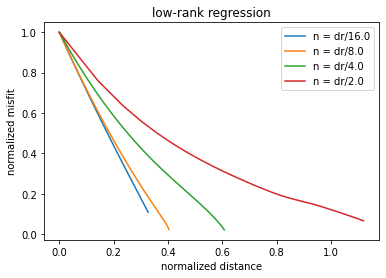

In [11]:
fig = plt.figure()
for elem in result_arr:
    x_axis = [iter_dict['distance'] for iter_dict in elem['arr']]
    y_axis = [iter_dict['misfit'] for iter_dict in elem['arr']]
    plt.plot(x_axis, y_axis, label=elem['name'])
plt.xlabel('normalized distance')
plt.ylabel('normalized misfit')
plt.title('low-rank regression')
plt.legend()
plt.savefig('low_rank_regression.jpeg', dpi=300)
plt.show()